In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import alexnet
from PIL import Image
import os
import numpy as np

Step 1: Use one of the deep learning frameworks (Pytorch, Tensorflow, Keras, ...) and
load the pre-trained AlexNet model. Input these 156 images to the pre-trained AlexNet
model and extract feature maps/activations from Conv 1, 2, 3, 4, 5, fc6, and fc7 layers.
Vectorize the activations corresponding to each image. You should have a vector of
activations per image per layer mentioned above.

In [ ]:
# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# load alex-net
model = alexnet(pretrained=True)
model.eval()

# activation containers
activations = {}
layers = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10', 'classifier.1', 'classifier.4']
for layer in layers:
    activations[layer] = []

def hook(module, input, output, name):
    """ captures activation """
    activations[name].append(output.flatten().detach().cpu().numpy())

# hook each layer
hooks = []
for name, layer in model.named_modules():
    if name in layers:
        hooks.append(layer.register_forward_hook(lambda module, input, output, name=name: hook(module, input, output, name)))

# image processing
folder = 'image_set'
files = []
for filename in sorted(os.listdir(folder)):
    path = os.path.join(folder, filename)
    try:
        image = Image.open(path).convert('RGB')
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            _ = model(image)
        files.append(filename)
    except Exception as e:
        print(f"Cannot process {filename}: {e}")

# removing hooks
for hook in hooks:
    hook.remove()

# numpy arrays
for layer in activations:
    activations[layer] = np.array(activations[layer])


Step 2. Create a representational dissimilarity matrix (RDM) which is 156 x156 matrix,
each row and column in this matrix is indexed by one of the images in the image set
and each element in the matrix is the Euclidean distance between the activation vectors
of the corresponding images you extracted in Step 1.

In [ ]:
def euclidean_distance(v1, v2):
    """ computes euclidean distance between vectors v1, v2 """
    return np.sqrt(np.sum((v1 - v2) ** 2))

# compute representational dissimilarity matrix (rdm)
rdms = {}
for layer in layers:
    n = activations[layer].shape[0]
    rdm = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            rdm[i, j] = euclidean_distance(activations[layer][i], activations[layer][j])
    rdms[layer] = rdm

Step 3. Plot the RDM for each layer (Conv 1, 2, 3, 4, 5, fc6, fc7), and their corresponding multidimensional scaling (MDS) visualization in 2 Dimension. The class
labels you should use for the MDS plotting includes images 1 to 28 are Animals, 29-64
are Objects, 65 to 100 are scenes, 101 to 124 are human activities, 125 to 156 are
faces.

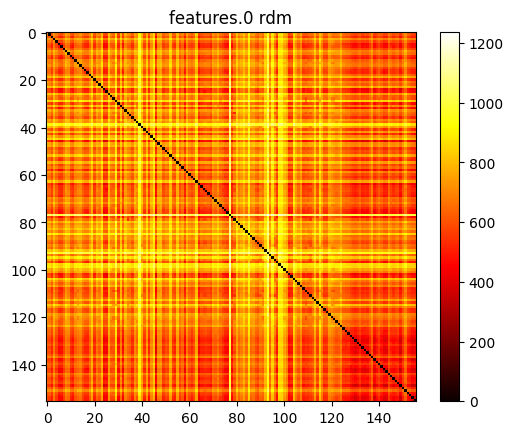

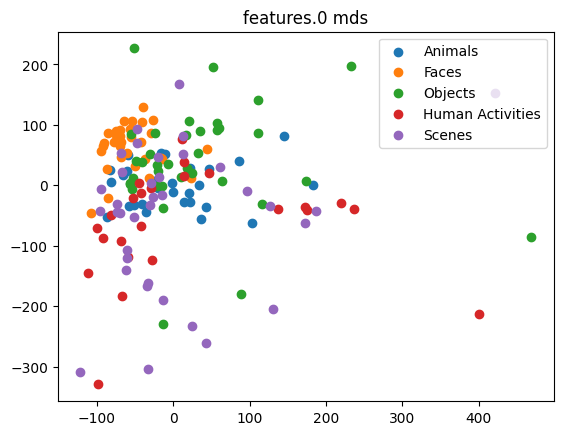

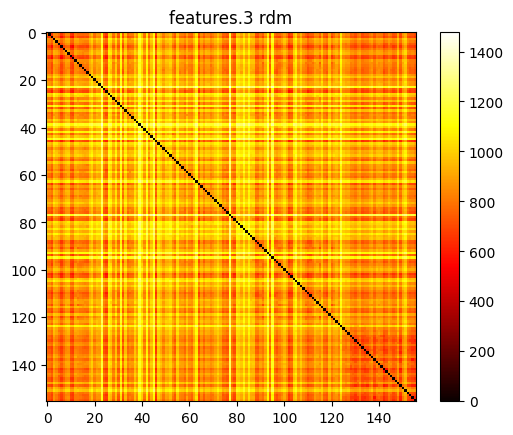

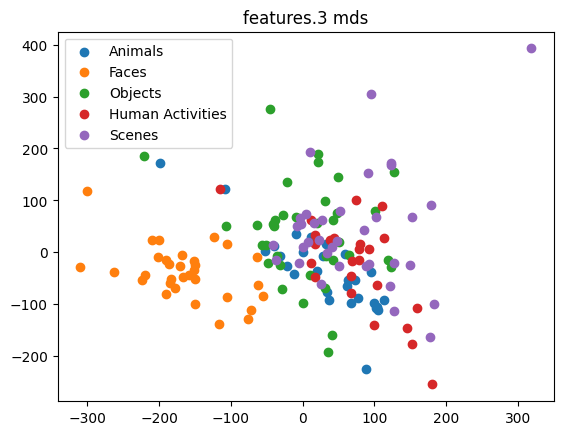

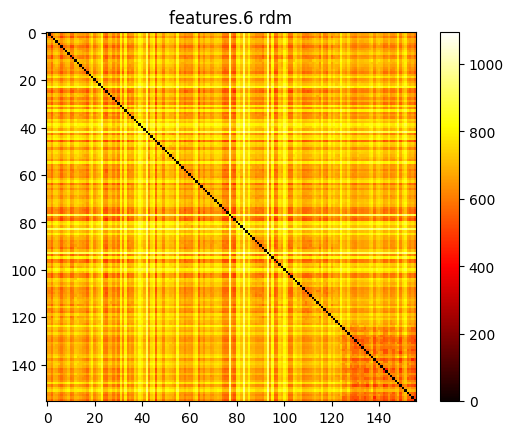

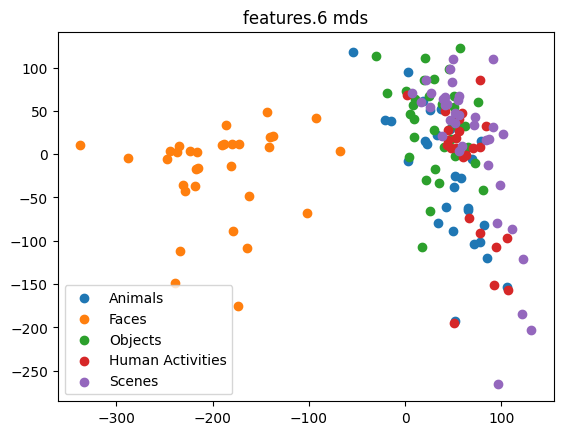

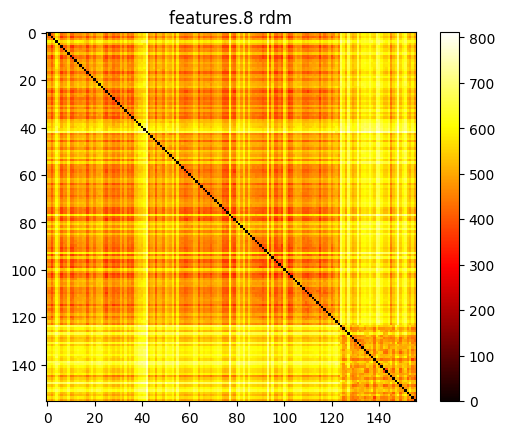

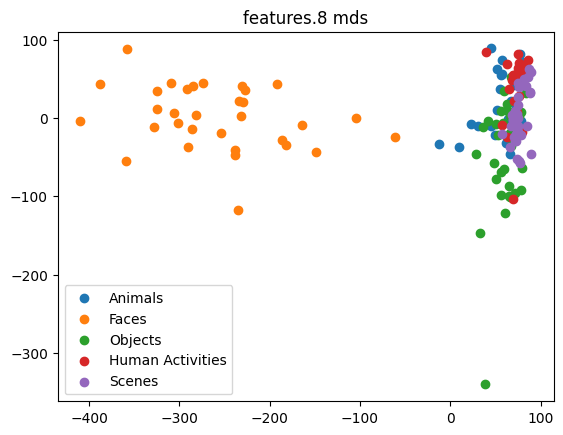

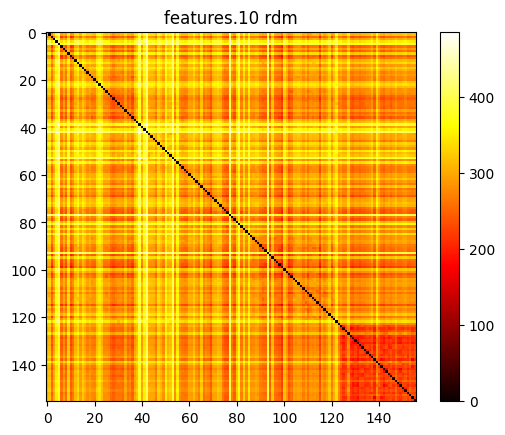

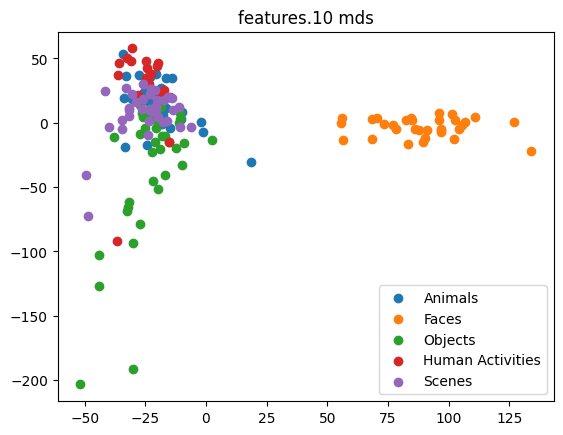

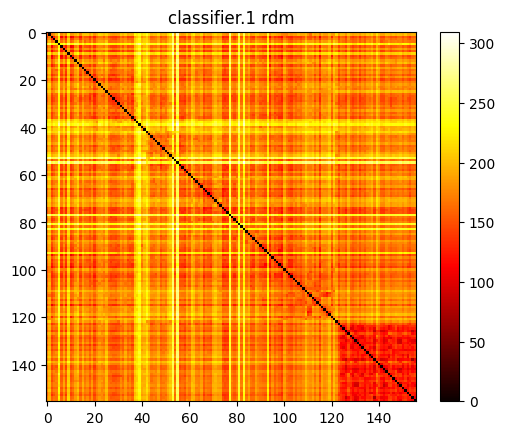

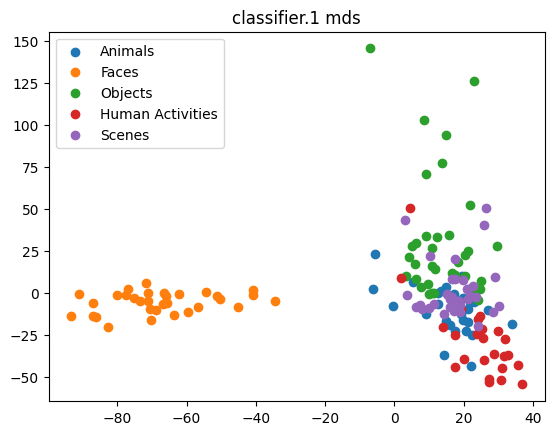

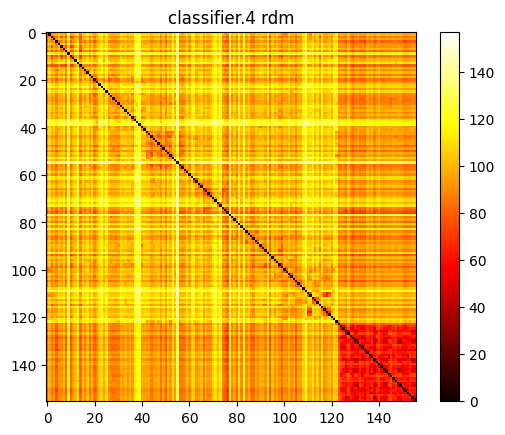

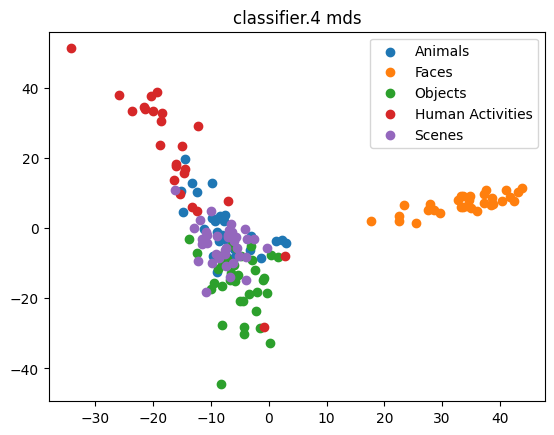

In [ ]:
import matplotlib.pyplot as plt

# class labels
labels = ['Animals'] * 28 + ['Objects'] * 36 + ['Scenes'] * 36 + ['Human Activities'] * 24 + ['Faces'] * 32

# multidimensional scaling (mds)
def mds(rdm, components=2):
    n = rdm.shape[0]

    # center matrix
    H = np.eye(n) - np.ones((n,n)) / n

    # double centering
    B = -0.5 * np.dot(np.dot(H, rdm ** 2), H)

    # eigen decomp
    eigen_vals, eigen_vecs = np.linalg.eigh(B)
    i = np.argsort(eigen_vals)[::-1]
    eigen_vals = eigen_vals[i]
    eigen_vecs = eigen_vecs[:, i]

    # coords calculation
    eigen_vals = np.sqrt(eigen_vals[:components])
    coords = eigen_vecs[:, :components] * eigen_vals[np.newaxis, :]

    return coords

# plotting rdm + mds
for layer in layers:
    rdm = rdms[layer]

    plt.imshow(rdm, cmap='hot', interpolation='nearest')
    plt.title(f"{layer} rdm")
    plt.colorbar()
    plt.show()

    coords = mds(rdm, components=2)
    for label in set(labels):
        index = []
        for i, cur_label in enumerate(labels):
            if cur_label == label:
                index.append(i)
        plt.scatter(coords[index, 0], coords[index, 1], label=label)
    plt.title(f"{layer} mds")
    plt.legend()
    plt.show()


# Findings

From the results, RDM and MDS plots, we can clearly see that early layers such as features.0 and features.3 have weak clustering, with no distinctions made between our labels, which means the early stages capture lower pixel-level features. Our middle layers such as features.6 and features.8 make stronger clustering between facing and objects, suggesting that we are starting to notice more complexities. Our latest layer, features.10, has even stronger clustering as our model is able to properly cluster animals and facing. The fully connected layers such as classifer.1 and classifier.4 have vivid clustering, which means our model as captured most of the necessary information to segment our categories.